# Backtest Class

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import keras.optimizers
import pickle
import time
import matplotlib.pyplot as plt

class backtest:
    def __init__(self,model,tickers,length):
        self.model = model
        self.tickers = tickers
        self.data = pd.DataFrame()
        self.length = length
        self.metrics_df = pd.DataFrame(columns = ['ticker','model_mape','ma_mape','model_accuracy','ma_accuracy'])
        
    def get_data(self):
        data =  yf.download(tickers = self.tickers, 
        period = self.length, interval = "15m", group_by = 'ticker',
        auto_adjust = True,
        prepost = False,
        threads = True,
        proxy = None
    )
        
        data = data.loc[:, pd.IndexSlice[:, ['Close']]]
        
        columns = data.columns.droplevel(1)
        
        data.columns = columns 
        
        data.sort_index(axis = 1, inplace = True)
        #data = data.reset_index(drop = True)
        return data.dropna()
    
    def predict(self,X):
        scaler = MinMaxScaler(feature_range=(0, 1))
        my_array = X.reshape(-1, 1)
        scaled_Close = scaler.fit_transform(my_array)
        scaled_X = scaled_Close.reshape((1, 1, 10))

        y = model.predict(scaled_X)
        b = scaler.inverse_transform(y)
        #r = (b[0] - X[-1]) / X[-1]
        return b[0][0]
        
        
        
        
        
    def get_X(self):
        for ticker in self.tickers:
            self.data[ticker+"_X"] = list(self.data[ticker].rolling(window=10))
            self.data[ticker+"_X"] = self.data[ticker+"_X"].apply(lambda x:x.values)
            
            scaler = MinMaxScaler(feature_range=(0, 1))
            
            
            #return
            self.data[ticker+"_ret"] = self.data[ticker]/self.data[ticker].shift(1)-1
            
            #create benchmark
            self.data[ticker+"_MA"] = self.data[ticker].rolling(10).mean().shift(1)
            
    
    def get_metrics(self):
        self.data = self.data.dropna(axis = 0)
        self.metrics_df = pd.DataFrame(columns = ['ticker','model_mape','ma_mape','model_accuracy','ma_accuracy'])
        for ticker in self.tickers:
            model_mape = mean_absolute_percentage_error(self.data[ticker],self.data[ticker+'_y_pred'])
            ma_mape = mean_absolute_percentage_error(self.data[ticker],self.data[ticker+'_MA'])
            
            model_acc = accuracy_score(self.data[ticker+'_pos_ret'],self.data[ticker+'_y_pred_pos_ret'])
            ma_acc = accuracy_score(self.data[ticker+'_pos_ret'],self.data[ticker+'_MA_pos_ret'])
            
            self.metrics_df.loc[len(self.metrics_df)] = [ticker,model_mape,ma_mape,model_acc,ma_acc]
            
        
    
    def get_metrics_by_date(self):
        bt.data['date'] = pd.to_datetime(bt.data.index).date
        res = pd.DataFrame()
        for ticker in self.tickers:
            res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absolute_percentage_error(x[ticker],x[ticker+"_y_pred"]))
            res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_score(x[ticker+"_pos_ret"],x[ticker+'_y_pred_pos_ret']))
        return res
    
    def backtest(self):
        self.data = self.get_data()
        self.get_X()
        self.data = self.data[11:]
        for ticker in self.tickers:

            #make prediction
            self.data[ticker+"_y_pred"] = self.data[ticker+"_X"].apply(lambda x:self.predict(x))
            #self.data[ticker+"_y_pred"] = self.data[ticker+"_y_pred"].shift(1)
            

            
            #get returns
            self.data[ticker+"_ret"] = self.data[ticker]/self.data[ticker].shift(1)-1
            self.data[ticker+"_y_pred_ret"] = self.data[ticker+"_y_pred"]/self.data[ticker]-1
            self.data[ticker+"_MA_ret"] = self.data[ticker+"_MA"]/self.data[ticker].shift(1)-1
    
            
            #turn to binary
            self.data[ticker+"_pos_ret"] = self.data[ticker+"_ret"].apply(lambda x: 0 if x<0 else 1)
            self.data[ticker+"_MA_pos_ret"] = self.data[ticker+"_MA_ret"].apply(lambda x: 0 if x<0 else 1)
            self.data[ticker+"_y_pred_pos_ret"] = self.data[ticker+"_y_pred_ret"].apply(lambda x: 0 if x<0 else 1)
        

# Demo

In [12]:
#prediction model used in backtest
model =  keras.models.load_model("stockprediction.h5")

#length in days(max 60d restricted by yfinance)
length = "1d"

#tickers for back test. sp100
with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

#initialize instance with parameteres
bt = backtest(model = model, length = length,tickers = ["AAPL","GOOG"])

In [13]:
#begin backtest
start = time.time()
bt.backtest()
end = time.time()
print(end - start)

[*********************100%***********************]  2 of 2 completed
1/1 [==============================] - 0s 19ms/step
2.2249248027801514


In [14]:
bt.data

,AAPL,GOOG,AAPL_X,AAPL_ret,AAPL_MA,GOOG_X,GOOG_ret,GOOG_MA,AAPL_y_pred,AAPL_y_pred_ret,AAPL_MA_ret,AAPL_pos_ret,AAPL_MA_pos_ret,AAPL_y_pred_pos_ret,GOOG_y_pred,GOOG_y_pred_ret,GOOG_MA_ret,GOOG_pos_ret,GOOG_MA_pos_ret,GOOG_y_pred_pos_ret
Datetime,,,,,,,,,,,,,,,,,,,,
2022-08-04 12:15:00-04:00,165.550003,118.900002,"[165.55999755859375, 164.95989990234375, 164.8...",NaN,165.216351,"[118.62000274658203, 118.27300262451172, 118.0...",NaN,118.440302,165.255219,-0.001781,NaN,1,1,0,118.559822,-0.002861,NaN,1,1,0
2022-08-04 12:30:00-04:00,165.309998,118.565002,"[164.95989990234375, 164.82000732421875, 165.3...",-0.001450,165.149352,"[118.27300262451172, 118.00700378417969, 118.5...",-0.002817,118.423302,165.247650,-0.000377,-0.002420,0,0,0,118.546715,-0.000154,-0.004009,0,0,0
2022-08-04 12:45:00-04:00,164.960007,118.279999,"[164.82000732421875, 165.310302734375, 164.710...",-0.002117,165.124352,"[118.00700378417969, 118.51000213623047, 117.9...",-0.002404,118.417802,165.178070,0.001322,-0.001123,0,0,1,118.483246,0.001718,-0.001242,0,0,1
2022-08-04 13:00:00-04:00,165.345001,118.489998,"[165.310302734375, 164.7100067138672, 164.7194...",0.002334,165.124362,"[118.51000213623047, 117.9800033569336, 118.12...",0.001775,118.418501,165.231155,-0.000689,0.000996,1,1,0,118.502884,0.000109,0.001171,1,1,1
2022-08-04 13:15:00-04:00,165.455002,118.800003,"[164.7100067138672, 164.71949768066406, 164.94...",0.000665,165.176862,"[117.9800033569336, 118.12000274658203, 118.28...",0.002616,118.466801,165.271957,-0.001106,-0.001017,1,0,0,118.561813,-0.002005,-0.000196,1,0,0
2022-08-04 13:30:00-04:00,165.264999,118.709999,"[164.71949768066406, 164.94000244140625, 165.3...",-0.001148,165.191331,"[118.12000274658203, 118.28800201416016, 118.6...",-0.000758,118.495801,165.275833,0.000066,-0.001594,0,0,1,118.606758,-0.000870,-0.002561,0,0,0
2022-08-04 13:45:00-04:00,165.259995,118.709999,"[164.94000244140625, 165.38380432128906, 165.5...",-0.000030,165.246831,"[118.28800201416016, 118.65499877929688, 118.8...",0.000000,118.568800,165.298004,0.000230,-0.000110,0,0,1,118.648750,-0.000516,-0.001189,1,0,0
2022-08-04 14:00:00-04:00,165.110001,118.510002,"[165.38380432128906, 165.5399932861328, 165.55...",-0.000908,165.300880,"[118.65499877929688, 118.87999725341797, 118.9...",-0.001685,118.627800,165.271378,0.000977,0.000247,0,1,1,118.633080,0.001039,-0.000692,0,0,1
2022-08-04 14:15:00-04:00,165.264999,118.779999,"[165.5399932861328, 165.5500030517578, 165.309...",0.000939,165.317880,"[118.87999725341797, 118.9000015258789, 118.56...",0.002278,118.650000,165.261169,-0.000023,0.001259,1,1,0,118.662239,-0.000991,0.001181,1,1,0


In [9]:
#get metrics by tickers, df store in the class as an attribute
bt.get_metrics()
bt.metrics_df.drop_duplicates()

,ticker,model_mape,ma_mape,model_accuracy,ma_accuracy
0,AAPL,0.005190,0.006664,0.497413,0.490944
1,ABBV,0.003851,0.004939,0.479301,0.480595
2,ABT,0.003830,0.004907,0.488357,0.481242
3,ACN,0.004856,0.006269,0.465718,0.460543
4,ADBE,0.005898,0.007407,0.514877,0.510996
...,...,...,...,...,...
95,VZ,0.003196,0.004095,0.481242,0.485123
96,WBA,0.004552,0.005811,0.476714,0.489651
97,WFC,0.005609,0.007259,0.492885,0.493532
98,WMT,0.003562,0.004565,0.495472,0.496766


In [10]:
#get metrics by ticker and date, return a new df
daily_result = bt.get_metrics_by_date()
daily_result

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absolute_percentage_error(x[ticker],x[ticker+"_y_pred"]))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_scor

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absolute_percentage_error(x[ticker],x[ticker+"_y_pred"]))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_scor

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_score(x[ticker+"_pos_ret"],x[ticker+'_y_pred_pos_ret']))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absol

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absolute_percentage_error(x[ticker],x[ticker+"_y_pred"]))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_scor

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_score(x[ticker+"_pos_ret"],x[ticker+'_y_pred_pos_ret']))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absol

/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_mape"] = bt.data.groupby(['date'])[[ticker,ticker+'_y_pred']].apply(lambda x: mean_absolute_percentage_error(x[ticker],x[ticker+"_y_pred"]))
/var/folders/qw/ly0bcf551mgdzlvs3rs3vqb80000gn/T/ipykernel_67747/2690421435.py:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[ticker+"_acc"] = bt.data.groupby(['date'])[[ticker+"_pos_ret",ticker+'_y_pred_pos_ret']].apply(lambda x: accuracy_scor

,AAPL_mape,AAPL_acc,ABBV_mape,ABBV_acc,ABT_mape,ABT_acc,ACN_mape,ACN_acc,ADBE_mape,ADBE_acc,...,VZ_mape,VZ_acc,WBA_mape,WBA_acc,WFC_mape,WFC_acc,WMT_mape,WMT_acc,XOM_mape,XOM_acc
date,,,,,,,,,,,,,,,,,,,,,
2022-04-27,0.004592,0.642857,0.002945,0.285714,0.004015,0.500000,0.003915,0.428571,0.004142,0.571429,...,0.002785,0.500000,0.003500,0.500000,0.002490,0.571429,0.002586,0.428571,0.003656,0.428571
2022-04-28,0.006271,0.500000,0.003809,0.538462,0.002215,0.692308,0.005577,0.269231,0.006100,0.538462,...,0.002511,0.538462,0.002037,0.576923,0.002767,0.576923,0.001870,0.538462,0.005170,0.384615
2022-04-29,0.006330,0.384615,0.017020,0.423077,0.005331,0.307692,0.005991,0.192308,0.005160,0.423077,...,0.006900,0.384615,0.006255,0.269231,0.004786,0.423077,0.003207,0.538462,0.004343,0.461538
2022-05-02,0.006910,0.384615,0.006605,0.615385,0.005972,0.423077,0.004881,0.615385,0.005548,0.653846,...,0.005286,0.423077,0.004409,0.500000,0.005413,0.461538,0.003621,0.423077,0.005238,0.500000
2022-05-03,0.004343,0.500000,0.005029,0.307692,0.004550,0.500000,0.003625,0.615385,0.004078,0.615385,...,0.004241,0.653846,0.003845,0.500000,0.005206,0.461538,0.003408,0.384615,0.005472,0.576923
2022-05-04,0.005456,0.461538,0.003349,0.615385,0.004869,0.384615,0.006382,0.307692,0.011027,0.230769,...,0.003683,0.346154,0.005744,0.307692,0.007003,0.423077,0.002663,0.500000,0.005056,0.500000
2022-05-05,0.008684,0.384615,0.003213,0.461538,0.004223,0.500000,0.008193,0.538462,0.008555,0.461538,...,0.002756,0.461538,0.004631,0.615385,0.009474,0.384615,0.003375,0.538462,0.005034,0.538462
2022-05-06,0.005758,0.500000,0.002743,0.576923,0.003717,0.538462,0.005431,0.576923,0.007163,0.653846,...,0.002867,0.500000,0.008198,0.384615,0.005722,0.538462,0.006440,0.538462,0.002973,0.769231
2022-05-09,0.005958,0.500000,0.004820,0.538462,0.005742,0.461538,0.004705,0.500000,0.007545,0.538462,...,0.002553,0.423077,0.003614,0.500000,0.005971,0.461538,0.004545,0.423077,0.012049,0.461538


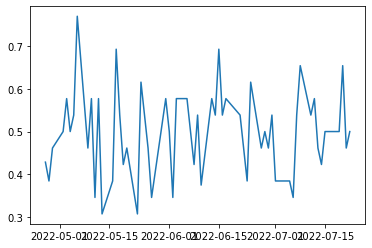

In [13]:
#some graphs
plt.plot(daily_result['XOM_acc'])